In [1]:
import ee
import geemap
import pandas as pd
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
import datetime
import pyproj

In [2]:
# Read pipe network and leaks loc
pipes_raw = gpd.read_file("../data/shp/Tuberias.shp")
leaks_raw = pd.read_excel("../data/raw/Ordenes Fugas Ejecutadas Dic2022 XY.xlsx")

In [3]:
# Define geometry from coords in leaks dataset
leaks_clean = leaks_raw.copy()
leaks_clean["geometry"] = gpd.points_from_xy(leaks_clean["X"], leaks_clean["Y"])

# Create gepandas gpd 
leaks_clean = gpd.GeoDataFrame(leaks_clean, geometry = "geometry")
pipes_clean = pipes_raw.copy()

In [4]:
pipes_clean.crs

<Compound CRS: COMPD_CS["WGS 84 / UTM zone 13N + NAVD88 height",P ...>
Name: WGS 84 / UTM zone 13N + NAVD88 height
Axis Info [cartesian|vertical]:
- [east]: Easting (metre)
- [north]: Northing (metre)
- [up]: Gravity-related height (metre)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
Sub CRS:
- WGS 84 / UTM zone 13N
- NAVD88 height

In [5]:
# leaks_clean = leaks_clean.set_crs("WGS 84")
leaks_clean.crs

In [ ]:
#pipes_clean.to_crs(4326)
#leaks_clean.to_crs(4326)

# Download 10x10 patch from GEE

In [18]:
ee.Initialize()
Map = geemap.Map()

In [19]:
# Coords of leaks
leak_lat_ogcrs = leaks_clean["Y"][0]
leak_lon_ogcrs = leaks_clean["X"][0]

# Transform to degrees
transformer = pyproj.Transformer.from_crs("epsg:32613", "epsg:4326")
leak_lon, leak_lat = transformer.transform(leak_lon_ogcrs, leak_lat_ogcrs)

# Point of leak
leak_poi = ee.Geometry.Point([leak_lat, leak_lon])

# Date of leak
end_date = leaks_clean["FECHALEGALIZACION"][0]
start_date = end_date - datetime.timedelta(10)

end_date = str(end_date)[:10]
start_date = str(start_date)[:10]

print((start_date, end_date))
print((leak_lat, leak_lon))

('2022-11-27', '2022-12-07')
(-102.27943290775767, 21.935910837898607)


In [20]:
collection = ee.ImageCollection("COPERNICUS/S2_SR")\
                .filterBounds(leak_poi)\
                .filterDate(ee.Date(start_date), ee.Date(end_date))

print("Images: ", collection.size().getInfo())

collection_list = collection.toList(collection.size())

Images:  4


In [21]:
bands = ["B2"]

img0 = ee.Image(collection_list.get(0))
img0 = img0.select(bands)

# Clip patch size
img0 = img0.clip(leak_poi.buffer(100).bounds())


viz_params = {
    "bands": ["B2"],
    "min": 0,
    "max": 3000
}

# Map.setCenter(leak_lat, leak_lon)
Map.addLayer(img0, viz_params, "img0")
Map.centerObject(img0)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [22]:
# Download ee patch
url = img0.getDownloadURL({
    "scale": 10,
    "crs": "EPSG:32613",
    "fileFormat": "GeoTIFF",
    "maxPixels": 1e13
})

print(url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5058132913ba938f2f57a93a749e8398-8288a8f07c3b3c91311809248a1b9fe4:getPixels


In [ ]:
# Check crs of satellite image
img0.crs.data

## Clip GeoTIFF with rasterio

In [4]:
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from rasterio.crs import CRS
from shapely.geometry import box
from shapely.geometry import Point
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import matplotlib.pyplot as plt

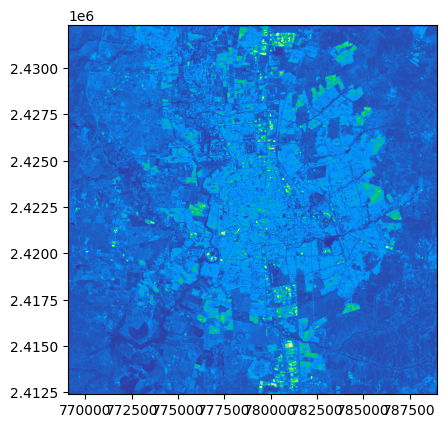

<AxesSubplot: >

In [5]:
# Read geotiff
img1 = rio.open("../data/images/20221210T171721_20221210T172008_T13QGE.B2.tif")

show((img1, 1), cmap = "terrain")

In [6]:
poi = Point(leaks_clean["X"][0], leaks_clean["Y"][0])
poi_patch = poi.buffer(100, cap_style = 3)

In [7]:
geo = gpd.GeoDataFrame({"geometry": poi_patch}, index = [0], crs = from_epsg(32613))

In [11]:
geo

,geometry
0,"POLYGON ((781121.888 2428326.907, 781121.888 2..."


<AxesSubplot: >

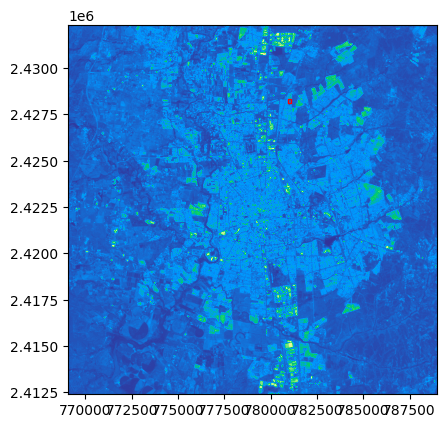

In [8]:
# Lets plot the patch over the full image
fig, ax = plt.subplots()
show((img1, 1), cmap = "terrain", ax = ax)
geo.plot(ax = ax, edgecolor = "red")

In [9]:
import rioxarray
img1 = rioxarray.open_rasterio("../data/images/20221210T171721_20221210T172008_T13QGE.B2.tif")

# Crop raster with bounding box
img1_clip = img1.rio.clip_box(*geo.total_bounds)

# Save rioxarray patch
img1_clip.rio.to_raster("../data/patches/leak_no_patch_riox.tif")

Text(0.5, 1.0, 'Descarga directa Earth Engine\nbuffer 100 m (21px21p)')

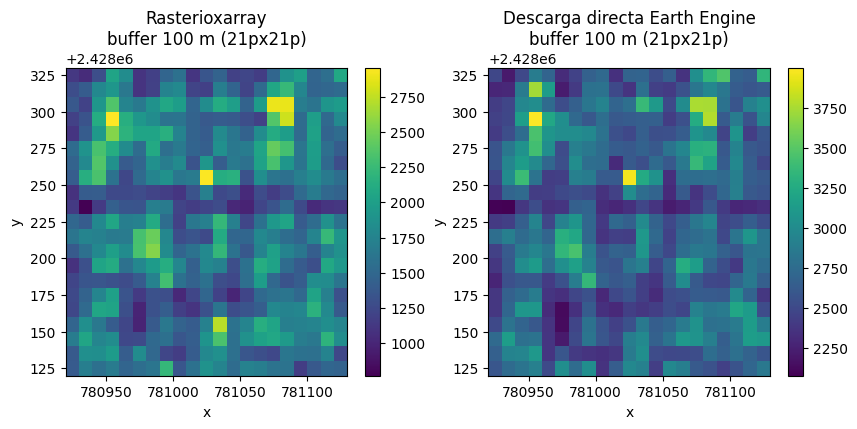

In [32]:
img1_clip_rio = rioxarray.open_rasterio("../data/patches/leak_no_patch_riox.tif")
img1_clip_ee = rioxarray.open_rasterio("../data/patches/20221128T172649_20221128T173505_T13QGE.B2.tif")

figure, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (10, 4))

img1_clip_rio.plot(ax = ax1)
ax1.set_title("Rasterioxarray\nbuffer 100 m (21px21p)")

img1_clip_ee.plot(ax = ax2)
ax2.set_title("Descarga directa Earth Engine\nbuffer 100 m (21px21p)")


In [74]:
img1.crs.data

{'init': 'epsg:32613'}

In [75]:
geo = geo.to_crs(crs = img1.crs.data)
geo

c:\Users\Erick\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,geometry
0,"POLYGON ((781000.000 2421000.000, 781000.000 2..."
